## Import dependencies

In [1]:
import sys, platform
from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import vispy as vp
import open3d as o3d
from tqdm import tqdm
import glfw
import OpenGL
import OpenGL.GL as GL
import OpenGL.GLU as GLU
import OpenGL.GL.shaders

print(platform.platform(), sys.platform)
print("Python", str(sys.version).replace('\n', ' '))
print(f"{np.__version__ = }")
print(f"{vp.__version__ = }")
print(f"{o3d.__version__ = }")
print(f"{OpenGL.__version__ = }")
print(f"{glfw.__version__ = }")

macOS-12.6.7-arm64-arm-64bit darwin
Python 3.12.11 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 08:03:38) [Clang 14.0.6 ]
np.__version__ = '2.3.3'
vp.__version__ = '0.15.2'
o3d.__version__ = '0.19.0'
OpenGL.__version__ = '3.1.10'
glfw.__version__ = '2.10.0'


objc[46663]: Class GLFWHelper is implemented in both /Users/metameta/anaconda3/envs/vrar-theory/lib/python3.12/site-packages/open3d/cpu/pybind.cpython-312-darwin.so (0x16d80fa28) and /Users/metameta/anaconda3/envs/vrar-theory/lib/python3.12/site-packages/glfw/libglfw.3.dylib (0x1755c9bb8). One of the two will be used. Which one is undefined.
objc[46663]: Class GLFWApplicationDelegate is implemented in both /Users/metameta/anaconda3/envs/vrar-theory/lib/python3.12/site-packages/open3d/cpu/pybind.cpython-312-darwin.so (0x16d80fa78) and /Users/metameta/anaconda3/envs/vrar-theory/lib/python3.12/site-packages/glfw/libglfw.3.dylib (0x1755c9c08). One of the two will be used. Which one is undefined.
objc[46663]: Class GLFWWindowDelegate is implemented in both /Users/metameta/anaconda3/envs/vrar-theory/lib/python3.12/site-packages/open3d/cpu/pybind.cpython-312-darwin.so (0x16d80faa0) and /Users/metameta/anaconda3/envs/vrar-theory/lib/python3.12/site-packages/glfw/libglfw.3.dylib (0x1755c9c30). 

## Open3D (pop-up window)

In [2]:
obj_file = "bunny_300tri.obj"
mesh = o3d.io.read_triangle_mesh(obj_file)
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(mesh)
vis.run()
vis.destroy_window()

[Open3D WARNING] Unable to load file bunny_300tri.obj with ASSIMP: Unable to open file "bunny_300tri.obj".
[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


## OpenGL (pop-up window or not)

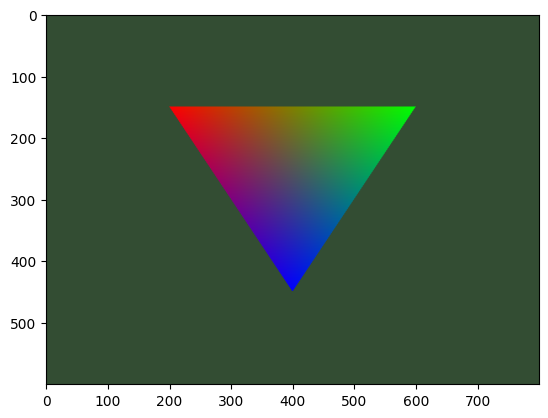

In [5]:
POPUP_WINDOW = 0
DISPLAY_WIDTH = 800
DISPLAY_HEIGHT = 600
def main() -> Union[None, np.ndarray]:
 
    # initialize glfw
    if not glfw.init():
        return
    
    # https://www.reddit.com/r/opengl/comments/14oazju/version_330_is_not_supported_m1_mac/?tl=ko -->
    # https://www.glfw.org/faq.html#41---how-do-i-create-an-opengl-30-context
    glfw.window_hint(glfw.CONTEXT_VERSION_MAJOR, 3);
    glfw.window_hint(glfw.CONTEXT_VERSION_MINOR, 3);
    glfw.window_hint(glfw.OPENGL_FORWARD_COMPAT, GL.GL_TRUE);
    glfw.window_hint(glfw.OPENGL_PROFILE, glfw.OPENGL_CORE_PROFILE);

    if not POPUP_WINDOW:
        glfw.window_hint(glfw.VISIBLE, False)

    window = glfw.create_window(DISPLAY_WIDTH, DISPLAY_HEIGHT, "My OpenGL window", None, None)
 
    if not window:
        glfw.terminate()
        return
 
    glfw.make_context_current(window)
    #            positions        colors
    triangle = [-0.5, -0.5, 0.0, 1.0, 0.0, 0.0,
                 0.5, -0.5, 0.0, 0.0, 1.0, 0.0,
                 0.0,  0.5, 0.0, 0.0, 0.0, 1.0]
 
    triangle = np.array(triangle, dtype = np.float32)
 
    vertex_shader = """
    #version 330
    in vec3 position;
    in vec3 color;
    out vec3 newColor;
    void main()
    {
        gl_Position = vec4(position, 1.0f);
        newColor = color;
    }
    """
 
    fragment_shader = """
    #version 330
    in vec3 newColor;
    out vec4 outColor;
    void main()
    {
        outColor = vec4(newColor, 1.0f);
    }
    """
    # https://stackoverflow.com/questions/62209242/pyopengl-test-program-getting-the-validation-failed-no-vertex-array-object-bou
    vao = GL.glGenVertexArrays(1)
    GL.glBindVertexArray(vao)

    shader = OpenGL.GL.shaders.compileProgram(OpenGL.GL.shaders.compileShader(vertex_shader, GL.GL_VERTEX_SHADER),
                                              OpenGL.GL.shaders.compileShader(fragment_shader, GL.GL_FRAGMENT_SHADER))
 
    VBO = GL.glGenBuffers(1)
    GL.glBindBuffer(GL.GL_ARRAY_BUFFER, VBO)
    GL.glBufferData(GL.GL_ARRAY_BUFFER, 72, triangle, GL.GL_STATIC_DRAW)
 
    position = GL.glGetAttribLocation(shader, "position")
    GL.glVertexAttribPointer(position, 3, GL.GL_FLOAT, GL.GL_FALSE, 24, GL.ctypes.c_void_p(0))
    GL.glEnableVertexAttribArray(position)
 
    color = GL.glGetAttribLocation(shader, "color")
    GL.glVertexAttribPointer(color, 3, GL.GL_FLOAT, GL.GL_FALSE, 24, GL.ctypes.c_void_p(12))
    GL.glEnableVertexAttribArray(color)
 
 
    GL.glUseProgram(shader)
 
    GL.glClearColor(0.2, 0.3, 0.2, 1.0)
    
    if POPUP_WINDOW:
        while not glfw.window_should_close(window):
            glfw.poll_events()
    
            GL.glClear(GL.GL_COLOR_BUFFER_BIT)
    
            GL.glDrawArrays(GL.GL_TRIANGLES, 0, 3)
    
            glfw.swap_buffers(window)
        glfw.terminate()
    else:
        
        GL.glClear(GL.GL_COLOR_BUFFER_BIT)
        GL.glDrawArrays(GL.GL_TRIANGLES, 0, 3)
        image_buffer = GL.glReadPixels(0, 0, DISPLAY_WIDTH, DISPLAY_HEIGHT, GL.GL_RGB, GL.GL_UNSIGNED_BYTE)
        image = np.frombuffer(image_buffer, dtype=np.uint8).reshape(DISPLAY_HEIGHT, DISPLAY_WIDTH, 3)

        glfw.destroy_window(window)
        return image
 
    
if POPUP_WINDOW:
    main()
else:
    plt.imshow(main());